## Pelatihan Model LSTM

### 1. Import Library yang Dibutuhkan

In [46]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dropout
import matplotlib.pyplot as plt
import yfinance as yf # Digunakan untuk mengunduh data saham
import joblib # Digunakan untuk menyimpan scaler


# Atur style plot Matplotlib
plt.style.use('fivethirtyeight')

### 2. Mengunduh Data Saham (BBRI)
 Mengunduh data harga historis saham Bank Rakyat Indonesia (BBRI.JK) dari Yahoo Finance.

In [8]:
# %%
# Tentukan rentang waktu untuk data pelatihan
start_date = "2019-01-20"
end_date = "2025-07-14" # Gunakan tanggal yang relevan untuk pelatihan

# Unduh data saham BBRI.JK
# Menggunakan .JK untuk ticker di Bursa Efek Jakarta
df = yf.download('BBRI.JK', start=start_date, end=end_date)

C:\Users\Iqbal\AppData\Local\Temp\ipykernel_33420\2897301668.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('BBRI.JK', start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [9]:
# Tampilkan 5 baris pertama data
print("5 baris pertama data saham BBRI:")
print(df.head())

5 baris pertama data saham BBRI:
Price             Close         High          Low         Open     Volume
Ticker          BBRI.JK      BBRI.JK      BBRI.JK      BBRI.JK    BBRI.JK
Date                                                                     
2019-01-21  2463.705322  2483.155599  2463.705322  2463.705322   89020137
2019-01-22  2444.254883  2457.221675  2424.804433  2444.254883  131658634
2019-01-23  2444.254883  2470.188467  2418.321124  2437.771400  179807675
2019-01-24  2457.221680  2470.188472  2431.287921  2431.287921  193786497
2019-01-25  2450.738037  2476.671794  2450.738037  2476.671794  139857845


In [10]:
# Tampilkan informasi ringkas DataFrame
print("\nInformasi DataFrame BBRI:")
df.info()


Informasi DataFrame BBRI:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1573 entries, 2019-01-21 to 2025-07-11
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Close, BBRI.JK)   1573 non-null   float64
 1   (High, BBRI.JK)    1573 non-null   float64
 2   (Low, BBRI.JK)     1573 non-null   float64
 3   (Open, BBRI.JK)    1573 non-null   float64
 4   (Volume, BBRI.JK)  1573 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 73.7 KB


### 3. Visualisasi Riwayat Harga Penutupan
Memplot riwayat harga penutupan saham untuk melihat trennya.


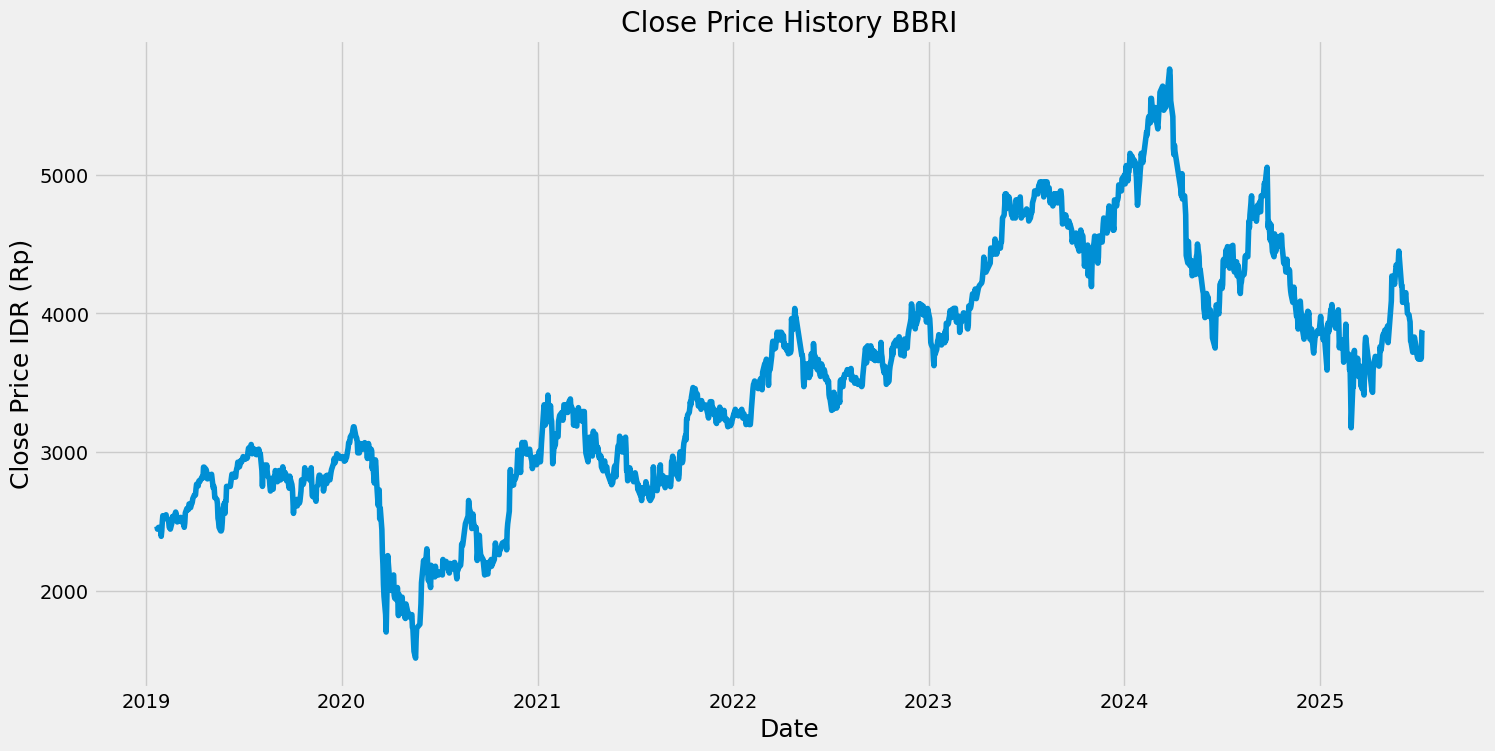

In [13]:
plt.figure(figsize=(16,8))
plt.title('Close Price History BBRI')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price IDR (Rp)', fontsize=18)
plt.show()

### 4. Preprocessing Data
Mempersiapkan data untuk model LSTM:
- Filter hanya kolom 'Close'.
- Normalisasi data menggunakan `MinMaxScaler`.
- Bagi data menjadi set pelatihan dan pengujian.
- Buat struktur data yang sesuai untuk LSTM (sequence).

In [16]:
if isinstance(df.columns, pd.MultiIndex):
    # Jika kolomnya multi-level (e.g., ('Close', 'BBRI.JK'))
    # Cari kolom 'Close' di level pertama MultiIndex
    close_column_name = [col for col in df.columns if 'Close' in col][0]
    data = df[close_column_name].to_frame() # Ambil kolom dan konversi kembali ke DataFrame
else:
    # Jika kolomnya standar (e.g., 'Close')
    data = df.filter(['Close'])

dataset = data.values

# Tentukan panjang data pelatihan (80% dari total data)
training_data_len = math.ceil(len(dataset) * .8)
print(f"Jumlah total data: {len(dataset)} hari")
print(f"Jumlah data pelatihan: {training_data_len} hari")

# Skala data ke rentang [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

print("\nContoh data yang sudah diskalakan (5 baris pertama):")
print(scaled_data[:5])

Jumlah total data: 1573 hari
Jumlah data pelatihan: 1259 hari

Contoh data yang sudah diskalakan (5 baris pertama):
[[0.22355179]
 [0.21897451]
 [0.21897451]
 [0.22202599]
 [0.22050019]]


### 5. Membuat Dataset Pelatihan
Mempersiapkan data `x_train` (fitur/input) dan `y_train` (target/output) dalam format sequence.
Kita akan menggunakan 60 hari sebelumnya untuk memprediksi harga hari berikutnya.


In [17]:
# Buat data pelatihan
train_data = scaled_data[0:training_data_len, :]

# Buat set data x_train dan y_train
x_train = []
y_train = []
look_back = 60 # Jumlah hari sebelumnya yang akan digunakan untuk prediksi

for i in range(look_back, len(train_data)):
    x_train.append(train_data[i-look_back:i, 0])
    y_train.append(train_data[i, 0])

# Konversi x_train dan y_train ke array NumPy
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape data untuk LSTM (sampel, timesteps, fitur)
# timesteps = look_back (60), fitur = 1 (harga penutupan)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print(f"Bentuk x_train: {x_train.shape}")
print(f"Bentuk y_train: {y_train.shape}")

Bentuk x_train: (1199, 60, 1)
Bentuk y_train: (1199,)


### 6. Membangun Model LSTM
Mendefinisikan arsitektur model LSTM menggunakan Keras Sequential API.

In [72]:


# model = Sequential()
# model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# model.add(Dropout(0.2)) # Menjatuhkan 20% neuron
# model.add(LSTM(100, return_sequences=False))
# model.add(Dropout(0.2)) # Menjatuhkan 20% neuron
# model.add(Dense(50))
# model.add(Dense(1))

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Kompilasi model
model.compile(optimizer='adam', loss='mean_squared_error')
# model.compile(optimizer='rmsprop', loss='mean_squared_error')

print("Model LSTM berhasil dibangun.")
model.summary()

Model LSTM berhasil dibangun.


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

### 7. Melatih Model
 Melatih model LSTM menggunakan data pelatihan.

In [73]:
print("Mulai melatih model LSTM...")
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
# model.fit(x_train, y_train, batch_size=1, epochs=20, verbose=1)
model.fit(x_train, y_train, batch_size=32, epochs=100, callbacks=[early_stop], verbose=1)
print("Pelatihan model LSTM selesai.")


Mulai melatih model LSTM...
Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0720
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0024
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 9.0302e-04
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.7884e-04
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.3853e-04
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.5519e-04
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.9163e-04
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 9.6145e-04
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.6109e-04
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.8969e-04
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.1762e-04
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.2820e-04
Epoch 13/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.0167e-04
Epoch 14/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step 

### 8. Membuat Dataset Pengujian dan Prediksi
Menyiapkan data pengujian dan menggunakan model yang telah dilatih untuk membuat prediksi.


In [74]:
# Buat set data pengujian
test_data = scaled_data[training_data_len - look_back:, :]

x_test = []
# y_test akan berisi nilai aktual untuk perbandingan
y_test = dataset[training_data_len:, :]

for i in range(look_back, len(test_data)):
    x_test.append(test_data[i-look_back:i, 0])

# Konversi x_test ke array NumPy
x_test = np.array(x_test)

# Reshape data untuk LSTM (sampel, timesteps, fitur)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print(f"Bentuk x_test: {x_test.shape}")
print(f"Bentuk y_test: {y_test.shape}")


# Dapatkan nilai harga yang diprediksi oleh model
predictions = model.predict(x_test)
# Invers transformasi prediksi kembali ke skala harga asli
predictions = scaler.inverse_transform(predictions)

print("\nPrediksi selesai.")
print("Contoh 5 prediksi pertama:", predictions[:5].flatten())
print("Contoh 5 nilai aktual y_test pertama:", y_test[:5].flatten())



Bentuk x_test: (314, 60, 1)
Bentuk y_test: (314, 1)
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Prediksi selesai.
Contoh 5 prediksi pertama: [5385.9336 5322.051  5395.363  5469.948  5483.845 ]
Contoh 5 nilai aktual y_test pertama: [5331.18896484 5397.27832031 5463.3671875  5485.39746094 5595.54541016]


### 9. Evaluasi Model (RMSE)
Menghitung Root Mean Squared Error (RMSE) untuk mengukur seberapa baik kinerja model.


In [75]:
rmse = np.sqrt(np.mean(((predictions - y_test)**2)))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Root Mean Squared Error (RMSE): 94.7558


### 10. Visualisasi Hasil Prediksi
Memplot harga pelatihan, harga aktual (validasi), dan harga yang diprediksi.

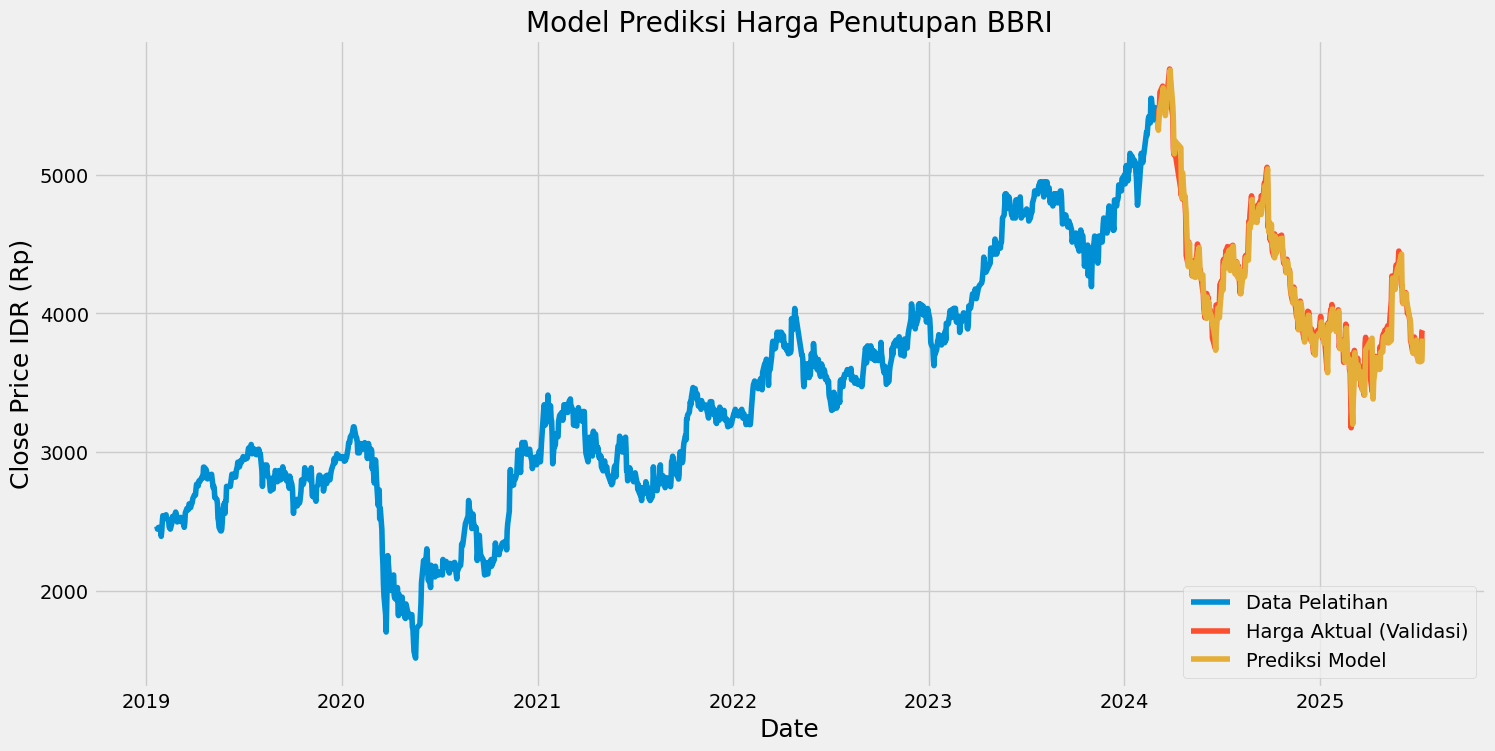

In [76]:
train = data[:training_data_len]
valid = data[training_data_len:].copy() # Gunakan .copy() untuk menghindari SettingWithCopyWarning
valid['Predictions'] = predictions

# Visualisasikan data
plt.figure(figsize=(16,8))
plt.title('Model Prediksi Harga Penutupan BBRI')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price IDR (Rp)', fontsize=18)
plt.plot(train['Close'], label='Data Pelatihan')
plt.plot(valid['Close'], label='Harga Aktual (Validasi)')
plt.plot(valid['Predictions'], label='Prediksi Model')
plt.legend(['Data Pelatihan', 'Harga Aktual (Validasi)', 'Prediksi Model'], loc='lower right')
plt.show()

In [77]:
print("\nTabel Validasi dan Prediksi (beberapa baris terakhir):")
print(valid.tail())



Tabel Validasi dan Prediksi (beberapa baris terakhir):
             Close  Predictions
           BBRI.JK             
Date                           
2025-07-07  3700.0  3651.190186
2025-07-08  3670.0  3676.164062
2025-07-09  3680.0  3657.792969
2025-07-10  3870.0  3657.957275
2025-07-11  3880.0  3819.390381


### 11. Prediksi Harga Hari Berikutnya
Menggunakan model untuk memprediksi harga penutupan untuk satu hari ke depan, berdasarkan 60 hari terakhir data yang tersedia.


In [78]:
# Ambil 60 hari terakhir dari data penutupan
last_60_days = df['Close'].tail(look_back).values

# Skala data 60 hari terakhir
last_60_days_scaled = scaler.transform(last_60_days.reshape(-1, 1))

# Siapkan input untuk prediksi (reshape ke (1, 60, 1))
X_pred = np.array([last_60_days_scaled.flatten()])
X_pred = np.reshape(X_pred, (X_pred.shape[0], X_pred.shape[1], 1))

# Dapatkan harga yang diprediksi
predicted_price_tomorrow_scaled = model.predict(X_pred)
predicted_price_tomorrow = scaler.inverse_transform(predicted_price_tomorrow_scaled)

print(f"\nHarga Penutupan BBRI yang Diprediksi untuk Hari Berikutnya: Rp {predicted_price_tomorrow[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Harga Penutupan BBRI yang Diprediksi untuk Hari Berikutnya: Rp 3870.30


In [79]:
# Simpan model dan scaler
model.save("bbri_lstm_model.h5")
joblib.dump(scaler, "bbri_scaler.pkl")
print("Model dan scaler berhasil disimpan.")

Model dan scaler berhasil disimpan.
